In [9]:
import numpy as np
import cv2

hs_folder = 'complete_ms_data/balloons_ms/balloons_ms/'

stacked_img = np.empty([512, 512, 31])

for i in range(1, 32):
    img_path = hs_folder + "balloons_ms_{:02d}.png".format(i)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    stacked_img[:, :, i-1] = img

print("Stacked image shape:", stacked_img.shape)

cropped_images = []
for h in range(0, 512-64+1, 32):
    for w in range(0, 512-64+1, 32):
        cropped_img = stacked_img[h:h+64, w:w+64, :]
        cropped_images.append(cropped_img)

cropped_images = np.array(cropped_images)

print("Cropped images shape:", cropped_images.shape)

LowResHSI = []
HiResRGB = []

for img in cropped_images:
    # Low-resolution HSI
    low_res_img = cv2.resize(img, (8, 8), interpolation=cv2.INTER_AREA)
    LowResHSI.append(low_res_img)
    
    # High-resolution RGB
    high_res_img = np.zeros((64, 64, 3))
    for i in range(3):
        high_res_img[:,:,i] = np.mean(img[:, :, i*10:(i+1)*10], axis=2)
    HiResRGB.append(high_res_img)

LowResHSI = np.array(LowResHSI)
HiResRGB = np.array(HiResRGB)

print("low_res_images images shape:", LowResHSI.shape)
print("high_res_images images shape:", HiResRGB.shape)

from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, UpSampling2D
# Create the target dataset (original high resolution hyperspectral images)
y = cropped_images

# Create the input dataset (low resolution hyperspectral images and high resolution RGB images)
# No need to concatenate the inputs, keep them separate
X_low_res_hsi = LowResHSI
X_hi_res_rgb = HiResRGB

print("Low resolution HSI images shape:", X_low_res_hsi.shape)
print("High resolution RGB images shape:", X_hi_res_rgb.shape)
print("Target images shape:", y.shape)

from sklearn.model_selection import train_test_split

# Split the datasets into training and testing sets
X_low_res_hsi_train, X_low_res_hsi_test, y_train, y_test = train_test_split(X_low_res_hsi, y, test_size=0.2, random_state=42)
X_hi_res_rgb_train, X_hi_res_rgb_test = train_test_split(X_hi_res_rgb, test_size=0.2, random_state=42)


print(f"X_low_res_hsi_train shape: {X_low_res_hsi_train.shape}")
print(f"X_hi_res_rgb_train shape: {X_hi_res_rgb_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_low_res_hsi_test shape: {X_low_res_hsi_test.shape}")
print(f"X_hi_res_rgb_test shape: {X_hi_res_rgb_test.shape}")
print(f"y_test shape: {y_test.shape}")
#print(f)

Stacked image shape: (512, 512, 31)
Cropped images shape: (225, 64, 64, 31)
low_res_images images shape: (225, 8, 8, 31)
high_res_images images shape: (225, 64, 64, 3)
Low resolution HSI images shape: (225, 8, 8, 31)
High resolution RGB images shape: (225, 64, 64, 3)
Target images shape: (225, 64, 64, 31)
X_low_res_hsi_train shape: (180, 8, 8, 31)
X_hi_res_rgb_train shape: (180, 64, 64, 3)
y_train shape: (180, 64, 64, 31)
X_low_res_hsi_test shape: (45, 8, 8, 31)
X_hi_res_rgb_test shape: (45, 64, 64, 3)
y_test shape: (45, 64, 64, 31)


In [10]:
# Normalize the input data

# Calculate the maximum pixel value
max_pixel_value = 255
X_low_res_hsi_train = X_low_res_hsi_train / max_pixel_value
X_low_res_hsi_test = X_low_res_hsi_test / max_pixel_value

max_pixel_value = 255
X_hi_res_rgb_train = X_hi_res_rgb_train / max_pixel_value
X_hi_res_rgb_test = X_hi_res_rgb_test / max_pixel_value

max_pixel_value = 255
y_train = y_train / max_pixel_value
y_test = y_test / max_pixel_value



In [11]:
import tensorflow as tf
from keras.layers import Conv2D, UpSampling2D, Concatenate, Input
from keras.models import Model

def create_model(input_shape_hsi=(8, 8, 31), input_shape_rgb=(64, 64, 3)):
    # Define the low resolution hyperspectral image feature extraction model
    hsi_input = Input(shape=input_shape_hsi)
    hsi_model = Conv2D(64, (3, 3), activation='relu', padding='same')(hsi_input)
    hsi_model = Conv2D(128, (3, 3), activation='relu', padding='same')(hsi_model)
    hsi_model = UpSampling2D((8, 8))(hsi_model)

    # Define the high resolution RGB image feature extraction model
    rgb_input = Input(shape=input_shape_rgb)
    rgb_model = Conv2D(64, (3, 3), activation='relu', padding='same')(rgb_input)

    # Fuse the extracted features
    fusion = Concatenate(axis=-1)([hsi_model, rgb_model])

    # Define the reconstruction model
    output = Conv2D(64, (3, 3), activation='relu', padding='same')(fusion)
    output = Conv2D(128, (3, 3), activation='relu', padding='same')(output)
    output = Conv2D(input_shape_hsi[-1], (3, 3), activation='sigmoid', padding='same')(output)

    # Define the model
    model = Model(inputs=[hsi_input, rgb_input], outputs=output)

    return model



In [12]:
# Create the model
model = create_model()

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')



In [13]:
# Train the model
history = model.fit([X_low_res_hsi_train, X_hi_res_rgb_train], y_train, epochs=10, batch_size=16, 
          validation_data=([X_low_res_hsi_test, X_hi_res_rgb_test], y_test))


Epoch 1/10
12/12 [==============================] - 10s 761ms/step - loss: 0.0811 - val_loss: 0.0320
Epoch 2/10
12/12 [==============================] - 8s 686ms/step - loss: 0.0487 - val_loss: 0.0320
Epoch 3/10
12/12 [==============================] - 8s 681ms/step - loss: 0.0487 - val_loss: 0.0320
Epoch 4/10
12/12 [==============================] - 8s 676ms/step - loss: 0.0487 - val_loss: 0.0320
Epoch 5/10
12/12 [==============================] - 8s 660ms/step - loss: 0.0487 - val_loss: 0.0320
Epoch 6/10
12/12 [==============================] - 8s 671ms/step - loss: 0.0487 - val_loss: 0.0320
Epoch 7/10
12/12 [==============================] - 8s 665ms/step - loss: 0.0487 - val_loss: 0.0320
Epoch 8/10
12/12 [==============================] - 8s 675ms/step - loss: 0.0487 - val_loss: 0.0320
Epoch 9/10
12/12 [==============================] - 8s 685ms/step - loss: 0.0487 - val_loss: 0.0320
Epoch 10/10
12/12 [==============================] - 8s 689ms/step - loss: 0.0487 - val_loss: 0.032

In [14]:
loss = model.evaluate([X_low_res_hsi_test, X_hi_res_rgb_test], y_test)
    
print("Test Loss: ", loss)

2/2 [==============================] - 0s 134ms/step - loss: 0.0320
Test Loss:  0.03202228993177414


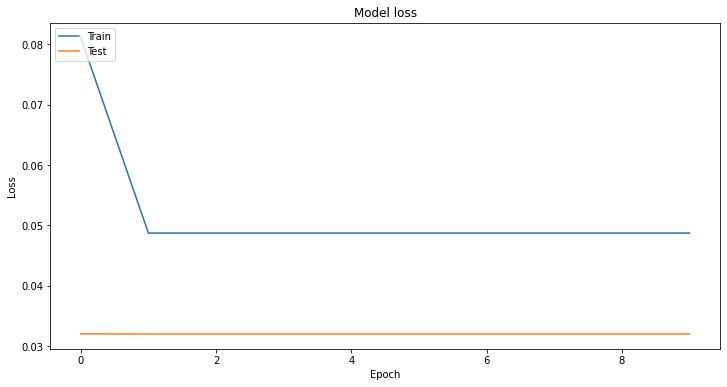

In [15]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Call the function to plot training history
plot_history(history)


2/2 [==============================] - 0s 141ms/step


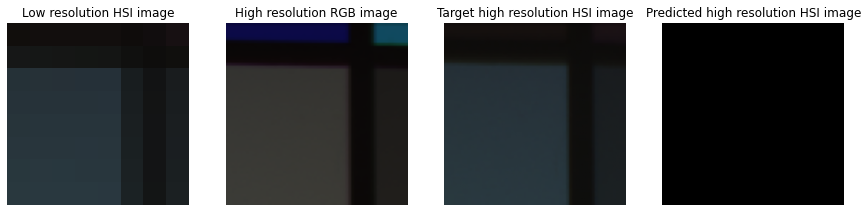

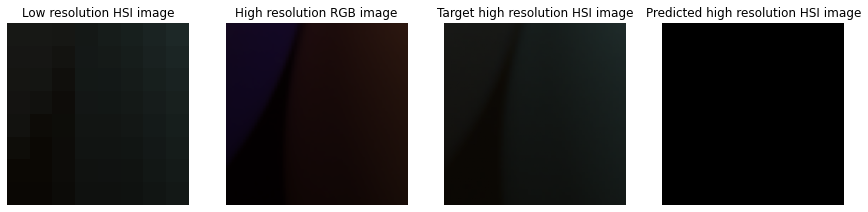

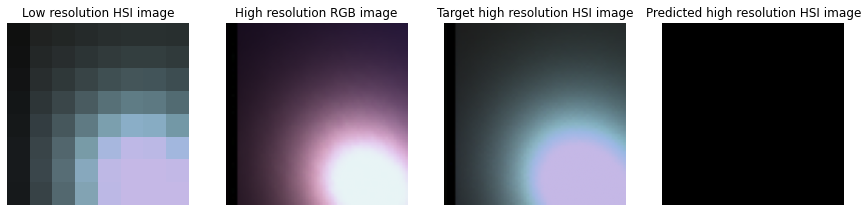

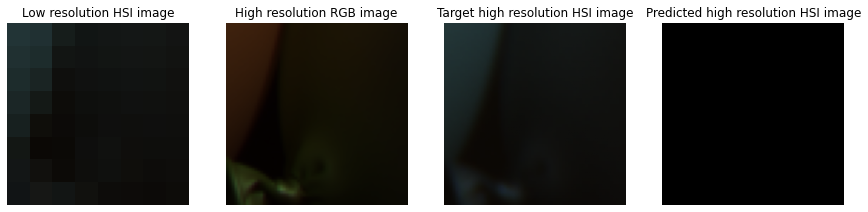

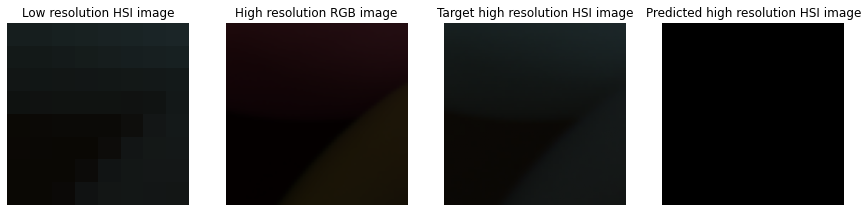

In [17]:
def plot_images(model, X_hsi_test, X_rgb_test, y_test):
    # Predict on the test images
    y_pred = model.predict([X_hsi_test, X_rgb_test])
    
    # Plot some test images and their predicted counterparts
    for i in range(5):
        fig, axs = plt.subplots(1, 4, figsize=(15, 5))
        
        # Plot the low resolution HSI image
        axs[0].imshow(X_hsi_test[i, :, :, :3])
        axs[0].set_title('Low resolution HSI image')

        # Plot the high resolution RGB image
        axs[1].imshow(X_rgb_test[i])
        axs[1].set_title('High resolution RGB image')

        # Plot the target high resolution HSI image
        axs[2].imshow(y_test[i, :, :, :3])
        axs[2].set_title('Target high resolution HSI image')
        
        # Plot the predicted high resolution HSI image
        axs[3].imshow(y_pred[i, :, :, :3])
        axs[3].set_title('Predicted high resolution HSI image')

        for ax in axs:
            ax.axis('off')

        plt.show()

# Call the function to plot some test images and their predicted counterparts
plot_images(model, X_low_res_hsi_test, X_hi_res_rgb_test, y_test)
